In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path2p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

from matrices_lib import spRandUMat, spRandUMatBase, spRandUMatFromBase, mergeMatBases, outerSP

# def randMat(NX, NY, sparcity, mu, std):
#     sparsityM = np.random.uniform(0, 1, NX*NY).reshape((NX, NY)) > sparcity
#     M = np.random.normal(mu, std, NX*NY).reshape((NX, NY))
#     M[sparsityM] = 0
#     return M

# Equation for neuron update
def computeR(r, W, T, p):
    pref = p['dt'] / p['tau_r']
    I_INT = np.divide(W.dot(r), T)
    rnew = r + pref * (p['r0'] - r + I_INT)
    rnew[rnew < 0] = 0.0   # Disallow rate to drop below zero
    return rnew

# Equation for neuron update - Order 2 rate - AKA critically-damped oscillator
def computeR2(r, i, M, T, p):
    order0 = p['zeta2'] * (M.dot(r[i]) + p['r0'] - r[i])
    order1 = p['czeta/2'] * r[i-1]
    order2 = 2*r[i] - r[i-1]
    rnew = p['pref'] * (order0 + order1 + order2)
    rnew[rnew < 0] = 0
    rnew[rnew > p['r_max']] = p['r_max']
    return rnew

# Equation for adapting threshold
def computeT(T, r, p):
    Tnew = T + p['eta_T'] * (r - p['r_T'])
    Tnew[Tnew < p['min_T']] = p['min_T']   # Threshold can't be negative
    Tnew[Tnew > p['max_T']] = p['max_T']   # Threshold has an upper bound
    
    return Tnew

Appended library directory /home/alyosha/work/memory-hippo-ca3/lib


## 1.1 Example: 1st order rate model, no plasticity

$$\tau_L \dot{r}_i = r^0_{i} - r_i + \frac{W_{ij}r_j + W^I_{i}r^I_i}{V^T_i - V^0_i}$$ 


$$r_i(t+1) = r_i(t) + \frac{dt}{\tau_L} \biggl( r^0_{i} - r_i + \frac{W_{ij}r_j + W^I_{i}r^I_i}{V^T_i - V^0_i} \biggr)$$

The average weight can be approximated by $W_0 = \frac{V^T - V^0}{\alpha_W (N-1)} \frac{R-R_0}{R}$ where $\alpha_W$ is the sparsity of the connectivity. We can define $\alpha_{IL} = \frac{R_0}{R}$ as the ratio between the ground state activity and expected state activity. It will determine the balance between leak and internal feedback input.

**Observations**:
* Global inhibition is not required to stabilize the system
* The system is stable for $a_{IL} \in (0, 1)$.
  * For $a_{IL} > 1$ attempts to have expected rate lower than base rate. It works, but results in negative leak, which is unphysical.
  * For $a_{IL} \leq 0$ the base rate is negligible compared to expected rate, or even negative. Results in explosion
  
**Problems**:
* The system does not exhibit any complex dynamics. The system quickly finds equillibrium, where all rates are fixed to some value.

**Solutions**:
* Read what rate models exist???
* Try 2nd order model?
* Does introducing limits to rate make it not settle to equillibria? I suppose no...

Average weight: 0.050505050505050504


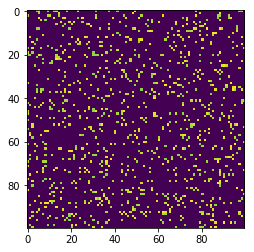

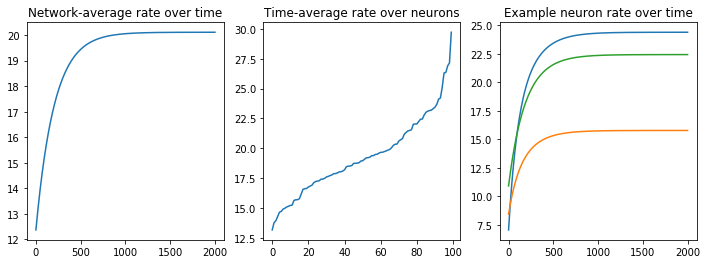

In [7]:
###############
# Initialization
###############

p = {
    "N"         : 100,    # Number of neurons
    "T0"        : 1.0,    # Average threshold
    "dt"        : 0.0001, # Time step
    "tau_r"     : 0.01,   # Leak timescale
    "r0"        : 10.0,   # Background activity
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "a_IL"      : 0.5     # Balance between internal feedback input and leak
}
p['W0'] = (1 - p['a_IL']) * p['T0'] / ((p['N'] - 1) * p['p_conn'])

# Initial values for variables
r = np.random.uniform(0.5 * p['r0'], 2.0 * p['r0'], p['N'])
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
W = spRandUMat([p['N'], p['N']], [0.9*p['W0'], 1.1*p['W0']], p['p_conn'], withDiag=False)

# # Plot connectivity
print('Average weight:', p['W0'])
plt.figure()
plt.imshow(W.toarray())
plt.show()

###############
# Simulation
###############

N_STEP = 2000

r_hist = np.zeros((N_STEP, p['N']))
r_hist[0] = r
    
for i in range(N_STEP-1):
    r = computeR(r, W, T, p)
    r_hist[i+1] = r
    
###############
# Analysis
###############

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].plot(np.mean(r_hist, axis=1))
ax[1].plot(np.sort(np.mean(r_hist, axis=0)))
ax[2].plot(r_hist[:, 0])
ax[2].plot(r_hist[:, 1])
ax[2].plot(r_hist[:, 2])

ax[0].set_title("Network-average rate over time")
ax[1].set_title("Time-average rate over neurons")
ax[2].set_title("Example neuron rate over time")
plt.show()

## Example 1.2: Add INH neurons

**Observations**:
* Network is still stable for most parameter choices
* Still no asymptotic activity - all rates find steady state
* Decreasing weight leads to higher activity, as opposed to example 1.1. This is because leak always tries to bring the value of the rate to $r_0$, but apparently growing both excitation and inhibition results in lower signal overall.
* For higher weights, some neurons are fully suppressed, as they receive more inhibition than excitation

Average EXC weight: 0.09090909090909091


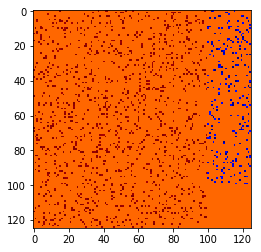

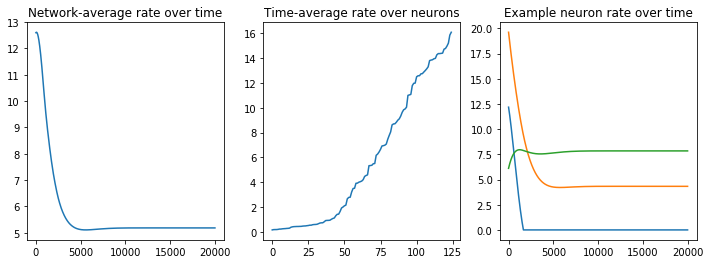

In [14]:
###############
# Initialization
###############

p = {
    "N_EXC"     : 100,    # Number of excitatory neurons
    "N_INH"     : 25,     # Number of inhibitory neurons
    "T0"        : 1.0,    # Average threshold
    "dt"        : 0.0001, # Time step
    "tau_r"     : 0.1,    # Leak timescale
    "r0"        : 10.0,   # Background activity
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "a_IL"      : 0.1     # Balance between internal feedback input and leak
}
p['W0_EXC'] = p['T0'] * (1 - p['a_IL']) / ((p['N_EXC'] - 1) * p['p_conn'])
p['W0_INH'] = p['W0_EXC'] * -4
p['N'] = p['N_EXC'] + p['N_INH']

# Initial values for variables
r = np.random.uniform(0.5 * p['r0'], 2.0 * p['r0'], p['N'])
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
rangeW = np.array([0.9, 1.1])
W_EE_BASE = spRandUMatBase([p['N_EXC'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=False)
W_EI_BASE = spRandUMatBase([p['N_INH'], p['N_EXC']], p['W0_EXC']*rangeW, p['p_conn'], withDiag=True)
W_IE_BASE = spRandUMatBase([p['N_EXC'], p['N_INH']], p['W0_INH']*rangeW, p['p_conn'], withDiag=True)
W_BASE = mergeMatBases([W_EE_BASE, W_EI_BASE, W_IE_BASE], [0, p['N_EXC'], 0], [0, 0, p['N_EXC']])
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# Plot connectivity
print('Average EXC weight:', p['W0_EXC'])
plt.figure()
plt.imshow(W.toarray(), cmap='jet')
plt.show()

###############
# Simulation
###############

N_STEP = 20000

r_hist = np.zeros((N_STEP, p['N']))
r_hist[0] = r
    
for i in range(N_STEP-1):
    r = computeR(r, W, T, p)
    r_hist[i+1] = r
    
###############
# Analysis
###############

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].plot(np.mean(r_hist, axis=1))
ax[1].plot(np.sort(np.mean(r_hist, axis=0)))
ax[2].plot(r_hist[:, 0])
ax[2].plot(r_hist[:, 1])
ax[2].plot(r_hist[:, 2])

ax[0].set_title("Network-average rate over time")
ax[1].set_title("Time-average rate over neurons")
ax[2].set_title("Example neuron rate over time")
plt.show()

## Example 1.3: No INH, Add HP

**Observation**:
* Having HP seems pointless for rate neurons as leak essentially does the same job already.

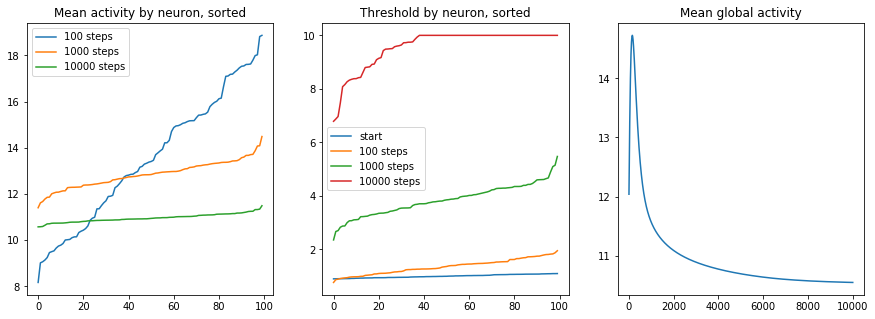

In [16]:
###############
# Initialization
###############

p = {
    "N"         : 100,    # Number of neurons
    "dt"        : 0.0001, # Time step
    "tau_r"     : 0.01,   # Leak timescale
    "r0"        : 10.0,   # Background activity
    "T0"        : 1.0,    # Average threshold
    "eta_T"     : 0.001,  # Threshold - homeostatic adaptation rate
    "min_T"     : 0.1,    # Threshold - homeostatic adaptation rate
    "max_T"     : 10.0,    # Threshold - homeostatic adaptation rate
    "r_T"       : 10.0,   # Threshold - homeostatic equillibtium neuron firing rate
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "a_IL"      : 0.5     # Balance between internal feedback input and leak
}
p['W0'] = (1 - p['a_IL']) * p['T0'] / ((p['N'] - 1) * p['p_conn'])

# Initial values for variables
r = np.random.uniform(0.5 * p['r0'], 2.0 * p['r0'], p['N'])
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
W = spRandUMat([p['N'], p['N']], [0.9*p['W0'], 1.1*p['W0']], p['p_conn'], withDiag=False)

# # Plot connectivity
# print('Average weight:', p['W0'])
# plt.figure()
# plt.imshow(M)
# plt.show()

###############
# Simulation
###############

N_STEP = 10000

r_hist = np.zeros((N_STEP, p['N']))
T_hist = np.zeros((N_STEP, p['N']))
r_hist[0] = r
T_hist[0] = T
    
for i in range(N_STEP-1):
    r = computeR(r, W, T, p)
    T = computeT(T, r, p)
    r_hist[i+1] = r
    T_hist[i+1] = T
    
###############
# Analysis
###############

freq100 = np.sort(np.mean(r_hist[:100], axis=0))
freq1000 = np.sort(np.mean(r_hist[:1000], axis=0))
freqAll = np.sort(np.mean(r_hist, axis=0))

T0    = np.sort(T_hist[0])
T100  = np.sort(T_hist[100])
T1000 = np.sort(T_hist[1000])
TLast = np.sort(T_hist[-1])
    
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(freq100, label='100 steps')
ax[0].plot(freq1000, label='1000 steps')
ax[0].plot(freqAll, label=str(N_STEP)+' steps')

ax[1].plot(T0, label='start')
ax[1].plot(T100, label='100 steps')
ax[1].plot(T1000, label='1000 steps')
ax[1].plot(TLast, label=str(N_STEP)+' steps')

ax[2].plot(np.mean(r_hist, axis=1))
#ax[2].plot(G_hist)

ax[0].set_title("Mean activity by neuron, sorted")
ax[1].set_title("Threshold by neuron, sorted")
ax[2].set_title("Mean global activity")

ax[0].legend()
ax[1].legend()
plt.show()

## Example 1.5: 1st order rate model with STDP

Hebbian STDP can be expressed as temporary increase in presynaptic rate, followed by temporary increase in postsynaptic rate.

$$
\dot{W}_{ij}
= \eta_W \bigl(\dot{R}_i(t+\Delta t) \dot{R}_j(t) - \dot{R}_i(t) \dot{R}_j(t+\Delta t) \bigr)
\approx \eta_W \Delta t \bigl(\ddot{R}_i \dot{R}_j - \dot{R}_i \ddot{R}_j \bigr)
$$

**TODO**:
  * Try increase delay
  * Read in literature if somebody even tried this

**Conclusion**:
  * So far this STDP is a bomb for amplifying numerical errors

Average weight: 0.050505050505050504


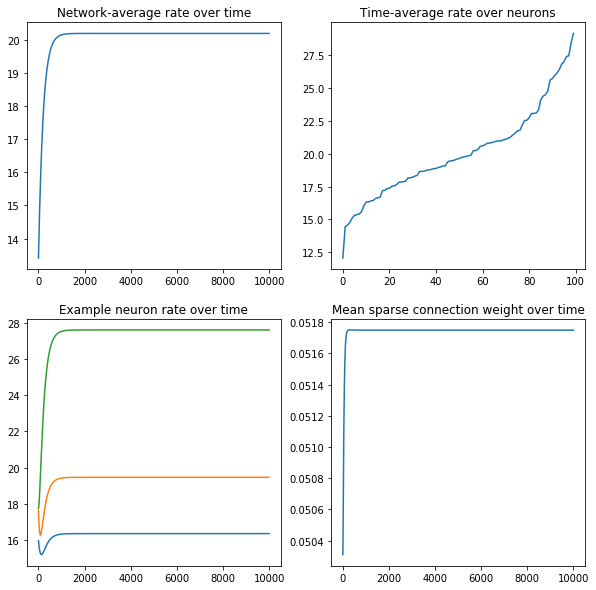

In [41]:
def threshold(M, vMin, vMax):
    M[M < vMin] = vMin
    M[M > vMax] = vMax

def updateW(W, W_BASE, R, p):
    # Compute derivatives
    DR  = (R[-1] - R[-3]) / 2
    DDR = R[-1] - 2*R[-2] + R[-3]

    idxRow = W_BASE[1][0]
    idxCol = W_BASE[1][1]
    
    HEBB_CAUS_1Dflat = outerSP(idxRow, idxCol, DDR, DR)
    HEBB_ANTI_1Dflat = outerSP(idxRow, idxCol, DR, DDR)
    
    W.data += p['eta_STDP'] * (HEBB_CAUS_1Dflat - HEBB_ANTI_1Dflat)
    
    threshold(W.data, p['min_W'], p['max_W'])
    
    
###############
# Initialization
###############

p = {
    "N"         : 100,    # Number of neurons
    "T0"        : 1.0,    # Average threshold
    "dt"        : 0.0001, # Time step
    "tau_r"     : 0.01,   # Leak timescale
    "r0"        : 10.0,   # Background activity
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "a_IL"      : 0.5,    # Balance between internal feedback input and leak
    "min_W"     : 0.01,   # Max weight
    "max_W"     : 4.0     # Max weight
}
p['W0'] = (1 - p['a_IL']) * p['T0'] / ((p['N'] - 1) * p['p_conn'])
p['eta_STDP'] = 0.001 / p['dt']  # Rate of STDP

# Initial values for variables
r = np.random.uniform(0.5 * p['r0'], 2.0 * p['r0'], p['N'])
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
W_BASE = spRandUMatBase([p['N'], p['N']], [0.9*p['W0'], 1.1*p['W0']], p['p_conn'], withDiag=False)
W = spRandUMatFromBase(W_BASE, [p['N'], p['N']])

# # Plot connectivity
print('Average weight:', p['W0'])
# plt.figure()
# plt.imshow(W.toarray())
# plt.show()

###############
# Simulation
###############

N_STEP = 10000

r_hist = np.zeros((N_STEP, p['N']))
r_hist[0] = r
W_hist = np.zeros(N_STEP)
W_hist[0] = np.mean(W.data)
    
for i in range(N_STEP-1):
    r = computeR(r, W, T, p)
    r_hist[i+1] = r
    
    if i > 1:
        updateW(W, W_BASE, r_hist[i-2:i+1], p)
        
    W_hist[i+1] = np.mean(W.data)
        
###############
# Analysis
###############

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))
ax[0][0].plot(np.mean(r_hist, axis=1))
ax[1][0].plot(r_hist[:, 0])
ax[1][0].plot(r_hist[:, 1])
ax[1][0].plot(r_hist[:, 2])
ax[0][1].plot(np.sort(np.mean(r_hist, axis=0)))
ax[1][1].plot(W_hist)

ax[0][0].set_title("Network-average rate over time")
ax[0][1].set_title("Time-average rate over neurons")
ax[1][0].set_title("Example neuron rate over time")
ax[1][1].set_title("Mean sparse connection weight over time")
plt.show()

## Example 1.6: 2nd order rate model, no plasticity

$$\tau^2 \ddot{r}_i = -(r_i - r_0) - c\tau\dot{r}_i + \sum_j \frac{W_{ij}}{T_{j}}r_j$$

Update rule

$$\tau^2 \frac{r_+ -2 r + r_-}{dt^2} = -(r - r_0) - c\tau \frac{r_+ - r_-}{2dt} + I$$

$$r_+ + \frac{c\zeta}{2} r_+ = -(r - r_0)\zeta^2 + \frac{c\zeta}{2} r_- + \zeta^2I + 2 r - r_-$$

$$r_+ = \biggl( \frac{1}{1 + \frac{c\zeta}{2}} \biggr) \biggl( -(r - r_0)\zeta^2 + \frac{c\zeta}{2} r_- + \zeta^2I + 2 r - r_- \biggr)$$

**Observations**:
* Conditionally stable - Need to bound rate from both sides
* Has periodic dynamics
  * Too high damping constant destroys dynamics - network finds equillibrium with all rates fixed

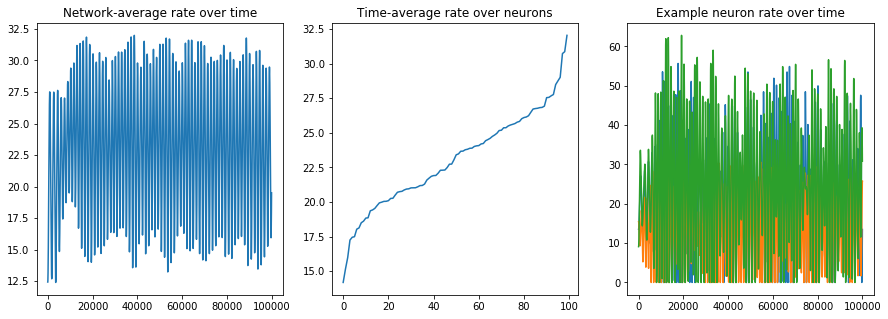

In [18]:
###############
# Initialization
###############

p = {
    "N"         : 100,    # Number of neurons
    "T0"        : 1.0,    # Average threshold
    "dt"        : 0.0001, # Time step
    "tau_r"     : 0.02,   # Leak timescale
    "r0"        : 10.0,   # Background activity
    "p_conn"    : 0.1,    # Ratio of number of existing connections to all-to-all
    "a_IL"      : 0.5,    # Balance between internal feedback input and leak
    "c"         : 0.0,    # Damping constant
    "r_max"     : 100.0   # Limit maximum neuron rate
}
p['W0'] = (1 - p['a_IL']) * p['T0'] / ((p['N'] - 1) * p['p_conn'])
p['zeta'] = p['dt'] / p['tau_r']
p['zeta2'] = p['zeta']**2
p['czeta/2'] = p['c'] * p['zeta'] / 2
p['pref'] = 1 / (1 + p['czeta/2'])

# Initial values for variables
r = np.random.uniform(0.5 * p['r0'], 2.0 * p['r0'], p['N'])
T = np.random.uniform(0.9 * p['T0'], 1.1 * p['T0'], p['N'])

# Connectivity matrix
W = spRandUMat([p['N'], p['N']], [0.9*p['W0'], 1.1*p['W0']], p['p_conn'], withDiag=False)

# # Plot connectivity
# print('Average weight:', p['W0'])
# plt.figure()
# plt.imshow(M)
# plt.show()

###############
# Simulation
###############

N_STEP = 100000

r_hist = np.zeros((N_STEP, p['N']))
r_hist[0] = r
r_hist[1] = np.copy(r)
    
for i in range(1, N_STEP-1):
    r = computeR2(r_hist, i, W, T, p)
    r_hist[i+1] = r
    
###############
# Analysis
###############

fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[0].plot(np.mean(r_hist, axis=1))
ax[1].plot(np.sort(np.mean(r_hist, axis=0)))
ax[2].plot(r_hist[:, 0])
ax[2].plot(r_hist[:, 1])
ax[2].plot(r_hist[:, 2])

ax[0].set_title("Network-average rate over time")
ax[1].set_title("Time-average rate over neurons")
ax[2].set_title("Example neuron rate over time")
plt.show()